In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%pip install torchinfo
from torchinfo import summary
import copy
import torch.optim as optim
import os
import time
from datasets import get_dataset,open_file,HyperX
from utils import build_dataset,sample_gt
from models import train, get_model
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.



# Datos

## Indian Pines

# Parameters

Ejecuta esta celda para trabajar en GPU

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Ejecuta esta celda para trabajar en CPU

In [3]:
device="cpu"

In [3]:
print(device)

cpu


hiperparámetros

In [5]:
dataset = 'IndianPines'
modelo="nn"
ipc = 10 # image(s) per class
num_eval = 20 # the number of evaluating randomly initialized models
epoch_eval_train = dicc[modelo].epoch_eval_train # epochs to train a model with synthetic data
Iteration = 1000 # training iterations
lr_img = 0.1 # learning rate for updating synthetic images
lr_net = dicc[modelo].lr_net # learning rate for updating network parameters
batch_real = dicc[modelo].batch_real # batch size for real data
batch_train = dicc[modelo]. batch_real# batch size for training networks

# Utils

In [6]:
class TensorDataset(Dataset):
    def __init__(self, images, labels): # images: n x c x h x w tensor
        self.images = images.detach().float()
        self.labels = labels.detach()

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]

In [6]:
nombre_datos="IndianPines"
ruta="Datasets/"
from torch.utils.data import TensorDataset, DataLoader

def obtener_datos(nombre,ruta):
    img, gt, LABEL_VALUES, IGNORED_LABELS, RGB_BANDS, palette = get_dataset(nombre,ruta)
    train_gt, test_gt = sample_gt(gt, 0.8, mode="random")
    X_train, y_train = build_dataset(img, train_gt, ignored_labels=IGNORED_LABELS)
    y_train=y_train-y_train.min()
    X_test,y_test=build_dataset(img, test_gt, ignored_labels=IGNORED_LABELS)
    y_test=y_test-y_test.min()
    canal=X_train.shape[-1]
    dim=len(X_train)
    num_clases=np.unique(y_train).size
    if nombre=="IndianPines":
        class_names=[
            "Alfalfa",
            "Corn-notill",
            "Corn-mintill",
            "Corn",
            "Grass-pasture",
            "Grass-trees",
            "Grass-pasture-mowed",
            "Hay-windrowed",
            "Oats",
            "Soybean-notill",
            "Soybean-mintill",
            "Soybean-clean",
            "Wheat",
            "Woods",
            "Buildings-Grass-Trees-Drives",
            "Stone-Steel-Towers"
        ]
    else:
        class_names=None
    mean=np.mean(img)
    std=np.std(img)
    
    tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
    tensor_y_train = torch.Tensor(y_train)
    tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
    tensor_y_test = torch.Tensor(y_test)
    
    dst_train = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
    #dst_train = DataLoader(dst_train)
    dst_test = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
    #dst_test = DataLoader(dst_test)
    testloader = torch.utils.data.DataLoader(dst_test, batch_size=256, shuffle=True, num_workers=2)
    return (
        canal,
        dim,
        num_clases,
        class_names,
        mean,
        std,
        dst_train,
        dst_test,
        testloader)

In [7]:
def get_loops(ipc):
    # Get the two hyper-parameters of outer-loop and inner-loop.
    # The following values are empirically good.
    if ipc == 1:
        outer_loop, inner_loop = 1, 1
    elif ipc == 10:
        outer_loop, inner_loop = 10, 50
    elif ipc == 20:
        outer_loop, inner_loop = 20, 25
    elif ipc == 30:
        outer_loop, inner_loop = 30, 20
    elif ipc == 40:
        outer_loop, inner_loop = 40, 15
    elif ipc == 50:
        outer_loop, inner_loop = 50, 10
    else:
        outer_loop, inner_loop = 0, 0
        exit('DC error: loop hyper-parameters are not defined for %d ipc'%ipc)
    return outer_loop, inner_loop

In [6]:
def get_images(c, n): # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]

In [7]:
def epoch(mode, dataloader, net, optimizer, criterion, device):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    net = net.to(device)
    criterion = criterion.to(device)

    if mode == 'train':
        net.train()
    else:
        net.eval()

    for i_batch, datum in enumerate(dataloader):
        img = datum[0].float().to(device)
        lab = datum[1].long().to(device)
        n_b = lab.shape[0]

        output = net(img)
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg

In [8]:
def evaluate_synset(net, images_train, labels_train, testloader, learningrate, batchsize_train, device, Epoch = 600):
    net = net.to(device)
    images_train = images_train.to(device)
    labels_train = labels_train.to(device)
    lr = float(learningrate)
    lr_schedule = [Epoch//2+1]
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss().to(device)

    dst_train = TensorDataset(images_train, labels_train)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size=batchsize_train, shuffle=True, num_workers=0)

    for ep in range(Epoch+1):
        loss_train, acc_train = epoch('train', trainloader, net, optimizer, criterion, device)
        if ep in lr_schedule:
            lr *= 0.1
            optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    loss_test, acc_test = epoch('test', testloader, net, optimizer, criterion, device)
    print('Evaluate: epoch = %04d, train loss = %.6f, train acc = %.4f, test acc = %.4f' % (Epoch, loss_train, acc_train, acc_test))

    return net, acc_train, acc_test

# Match loss

In [9]:
def distance_wb(gwr, gws):
    shape = gwr.shape
    if len(shape) == 4: # conv, out*in*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2] * shape[3])
        gws = gws.reshape(shape[0], shape[1] * shape[2] * shape[3])
    elif len(shape) == 3:  # layernorm, C*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2])
        gws = gws.reshape(shape[0], shape[1] * shape[2])
    elif len(shape) == 2: # linear, out*in
        tmp = 'do nothing'
    elif len(shape) == 1: # batchnorm/instancenorm, C; groupnorm x, bias
        gwr = gwr.reshape(1, shape[0])
        gws = gws.reshape(1, shape[0])
        return 0

    dis_weight = torch.sum(1 - torch.sum(gwr * gws, dim=-1) / (torch.norm(gwr, dim=-1) * torch.norm(gws, dim=-1) + 0.000001))
    dis = dis_weight
    return dis

def match_loss(gw_syn, gw_real):
    dis = torch.tensor(0.0).to(device)
    for ig in range(len(gw_real)):
        dis += distance_wb(gw_real[ig], gw_syn[ig])
    return dis

# Network

In [14]:
network = Baseline(channel,num_classes).to(device)
summary(network)

Layer (type:depth-idx)                   Param #
Baseline                                 --
├─Linear: 1-1                            411,648
├─Linear: 1-2                            8,392,704
├─Linear: 1-3                            8,390,656
├─Linear: 1-4                            32,784
Total params: 17,227,792
Trainable params: 17,227,792
Non-trainable params: 0

## Dataset

In [4]:
img, gt, LABEL_VALUES, IGNORED_LABELS, RGB_BANDS, palette = get_dataset("IndianPines", "Datasets/")
MODEL="nn"
hyperparams={'dataset': 'IndianPines',
             'model': MODEL,
             'folder':'./Datasets/',
             'cuda': -1,
             'runs': 1,
             'training_sample': 0.8,
             'sampling_mode': 'random',
             'class_balancing': False,
             'test_stride': 1,
             'flip_augmentation': False,
             'radiation_augmentation': False,
             'mixture_augmentation': False,
             'with_exploration': False,
             'n_classes':len(LABEL_VALUES),
             'n_bands':img.shape[-1],
             'ignored_labels': [0],
             'device': torch.device("cpu")}
model, optimizer, loss, hyperparams = get_model(MODEL,device, **hyperparams)
train_gt, test_gt = sample_gt(gt,hyperparams["training_sample"] , mode=hyperparams["sampling_mode"])
train_gt, val_gt = sample_gt(train_gt, 0.8, mode="random")
# Generate the dataset
train_dataset = HyperX(img, train_gt, **hyperparams)
train_loader = data.DataLoader(
    train_dataset,
    batch_size=hyperparams["batch_size"],
    shuffle=True,
)
val_dataset = HyperX(img, val_gt, **hyperparams)
val_loader = data.DataLoader(
    val_dataset,
    batch_size=hyperparams["batch_size"],
)

/media/hdspdeep/Disco2/Usuarios/Edinsson/DeepHyperX/utils.py:465: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_gt[train_indices] = gt[train_indices]
/media/hdspdeep/Disco2/Usuarios/Edinsson/DeepHyperX/utils.py:466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  test_gt[test_indices] = gt[test_indices]
/media/hdspdeep/Disco2/Usuarios/Edinsson/DeepHyperX/utils.py:465: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

In [7]:
def train(
    net,
    optimizer,
    criterion,
    data_loader,
    epoch,
    scheduler=None,
    device=torch.device("cpu"),
):
    """
    Training loop to optimize a network for several epochs and a specified loss

    Args:
        net: a PyTorch model
        optimizer: a PyTorch optimizer
        data_loader: a PyTorch dataset loader
        epoch: int specifying the number of training epochs
        criterion: a PyTorch-compatible loss function, e.g. nn.CrossEntropyLoss
        device (optional): torch device to use (defaults to CPU)
        display_iter (optional): number of iterations before refreshing the
        display (False/None to switch off).
        scheduler (optional): PyTorch scheduler
        val_loader (optional): validation dataset
        supervision (optional): 'full' or 'semi'
    """

    if criterion is None:
        raise Exception("Missing criterion. You must specify a loss function.")

    net.to(device)
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    iter_ = 1
    loss_win = None
    
    for e in tqdm(range(1, epoch + 1), desc="Training the network"):
        # Set the network to training mode
        net.train()
        avg_loss = 0.0

        # Run the training loop for one epoch
        for batch_idx, (data, target) in tqdm(
            enumerate(data_loader), total=len(data_loader)
        ):
            # Load the data into the GPU if required
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            losses[iter_] = loss.item()
            mean_losses[iter_] = np.mean(losses[max(0, iter - 100) : iter + 1])

            string = "Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}"
            string = string.format(
                e,
                epoch,
                batch_idx * len(data),
                len(data) * len(data_loader),
                100.0 * batch_idx / len(data_loader),
                mean_losses[iter_],
            )
           
            # tqdm.write(string)

        # Update the scheduler
        avg_loss /= len(data_loader)
train(
    model,
    optimizer,
    loss,
    train_loader,
    hyperparams["epoch"],
    scheduler=hyperparams["scheduler"],
    device=hyperparams["device"]
)

Training the network:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'

In [9]:
print(hyperparams["scheduler"])

In [8]:
from models import train
train(
    model,
    optimizer,
    loss,
    train_loader,
    hyperparams["epoch"],
    scheduler=hyperparams["scheduler"],
    device=hyperparams["device"]
)

Training the network:   1%|          | 1/100 [00:07<08:14,  4.99s/it]

Train (epoch 2/100) [3300/6600 (50%)]	Loss: 1.589256


100%|██████████| 66/66 [00:04<00:00, 13.70it/s]0:09<07:58,  4.88s/it]
                                                                     
Training the network:   3%|▎         | 3/100 [00:14<07:50,  4.85s/it]

Train (epoch 4/100) [100/6600 (2%)]	Loss: 1.316106


Training the network:   3%|▎         | 3/100 [00:15<08:17,  5.13s/it]


KeyboardInterrupt: 

In [ ]:
dataset = 'IndianPines'
modelo="nn"
ipc = 10 # image(s) per class
num_eval = 20 # the number of evaluating randomly initialized models
epoch_eval_train = dicc[modelo].epoch_eval_train # epochs to train a model with synthetic data
Iteration = 1000 # training iterations
lr_img = 0.1 # learning rate for updating synthetic images
lr_net = dicc[modelo].lr_net # learning rate for updating network parameters
batch_real = dicc[modelo].batch_real # batch size for real data
batch_train = dicc[modelo]. batch_real# batch size for training networks

In [16]:
print(vars(train_loader))

{'dataset': <datasets.HyperX object at 0x7f656b1c6220>, 'num_workers': 0, 'prefetch_factor': 2, 'pin_memory': False, 'timeout': 0, 'worker_init_fn': None, '_DataLoader__multiprocessing_context': None, '_dataset_kind': 0, 'batch_size': 100, 'drop_last': False, 'sampler': <torch.utils.data.sampler.RandomSampler object at 0x7f656b010220>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x7f656b070e50>, 'generator': None, 'collate_fn': <function default_collate at 0x7f6577263430>, 'persistent_workers': False, '_DataLoader__initialized': True, '_IterableDataset_len_called': None, '_iterator': None}


In [5]:
train(
    model,
    optimizer,
    loss,
    train_loader,
    hyperparams["epoch"],
    scheduler=hyperparams["scheduler"],
    device=hyperparams["device"],
    supervision=hyperparams["supervision"],
    val_loader=val_loader
)

Training the network:   0%|          | 0/100 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [15]:
outer_loop, inner_loop = get_loops(ipc) # Get the two hyper-parameters of outer-loop and inner-loop

In [6]:
print(train_loader.dataset.data.shape)

(145, 145, 200)


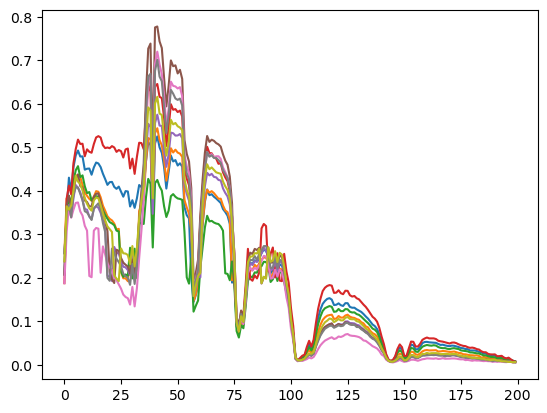

In [11]:

for i in [0,35,100]:
    for j in [4,70,144]:
        plt.plot(train_loader.dataset.data[i,j])

In [8]:
train_loader.dataset.data.shape

(145, 145, 200)

In [16]:
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))] # Save the images (1,1,28,28)
labels_all = [int(dst_train[i][1]) for i in range(len(dst_train))] # Save the labels

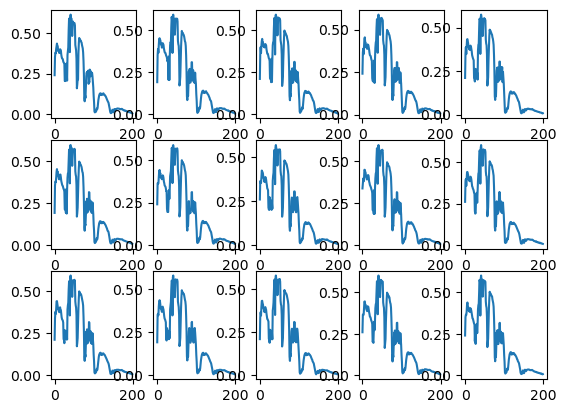

In [30]:
fig,axs=plt.subplots(3,5)
cont=-1
for i in range(3):
    for j in range(5):
        cont=cont+1
        axs[i,j].plot(images_all[cont][0])
fig.show()

Revolver los datos

In [21]:
import random
#funcion para intercambiar de posicion 2 elementos de un arreglo
def intercambiar(arreglo,ind1,ind2):
    temp=arreglo[ind1]
    arreglo[ind1]=arreglo[ind2]
    arreglo[ind2]=temp
    return arreglo
for i in range(len(labels_all)):
    ind=random.randint(0,len(labels_all)-1)
    images_all=intercambiar(images_all,i,ind)
    labels_all=intercambiar(labels_all,i,ind)

In [19]:
!CUDA_LAUNCH_BLOCKING=1
import os
os.system('CUDA_LAUNCH_BLOCKING=1')

0

In [20]:
print(len(range(Iteration+1)))

1001


In [21]:
for i, lab in enumerate(labels_all): # Save the index of each class labels
    indices_class[lab-1].append(i)
images_all = torch.cat(images_all, dim=0).to(device) # Cat images along the batch dimension
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device) # Make the labels a tensor

for c in range(num_classes):
    print('class c = %d: %d real images'%(c, len(indices_class[c]))) # Prints how many labels are for each class

class c = 0: 1142 real images
class c = 1: 664 real images
class c = 2: 190 real images
class c = 3: 386 real images
class c = 4: 584 real images
class c = 5: 23 real images
class c = 6: 382 real images
class c = 7: 16 real images
class c = 8: 778 real images
class c = 9: 1964 real images
class c = 10: 474 real images
class c = 11: 164 real images
class c = 12: 1012 real images
class c = 13: 309 real images
class c = 14: 74 real images
class c = 15: 37 real images


# Initialize syntethic images as noise

In [22]:
# Initialize syntethic data as noise, ipc = images per class
image_syn = torch.randn(size=(num_classes*ipc, channel), dtype=torch.float, requires_grad=True, device=device)
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

/tmp/ipykernel_22152/1721131830.py:3: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]
/tmp/ipykernel_22152/1721131830.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


## Training

In [23]:
#optimizer_img = torch.optim.SGD([image_syn, ], lr=lr_img, momentum=0.5) # optimizer_img for synthetic data
optimizer_img=optim.Adam([image_syn], lr=lr_net)
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(device) # Loss function

In [24]:
perdida=torch.empty(Iteration+1)
for it in range(Iteration+1):
    ''' Train synthetic data '''
    net = Baseline(channel, num_classes).to(device)
    net.train()
    net_parameters = list(net.parameters())
    optimizer_net = torch.optim.SGD(net.parameters(), lr=lr_net, momentum=0.5)  # optimizer_img for synthetic data
    optimizer_net.zero_grad()
    loss_avg = 0

    for ol in range(outer_loop):

        ''' update synthetic data '''
        loss = torch.tensor(0.0).to(device)
        for c in range(num_classes):
            img_real = get_images(c, batch_real)
            lab_real = torch.ones((img_real.shape[0],), device=device, dtype=torch.long) * c
            output_real = net(img_real)
            loss_real = criterion(output_real, lab_real)
            gw_real = torch.autograd.grad(loss_real, net_parameters)
            gw_real = list((_.detach().clone() for _ in gw_real))

            img_syn = image_syn[c*ipc:(c+1)*ipc].reshape((ipc, channel))
            lab_syn = torch.ones((ipc,), device=device, dtype=torch.long) * c
            output_syn = net(img_syn)
            loss_syn = criterion(output_syn, lab_syn)
            gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)

            loss += match_loss(gw_syn, gw_real)

        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step()
        loss_avg += loss.item()
        
        if ol == outer_loop - 1:
            break


        ''' update network '''
        image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())  # avoid any unaware modification
        dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
        trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=batch_train, shuffle=True, num_workers=0)
        for il in range(inner_loop):
            epoch('train', trainloader, net, optimizer_net, criterion, device)
            
    perdida[it]=loss_avg/outer_loop
    print("iteración: "+str(it)+"loss: "+str(perdida[it]))

iteración: 0loss: tensor(111526.3125)
iteración: 1loss: tensor(111249.2734)
iteración: 2loss: tensor(112015.5312)
iteración: 3loss: tensor(110944.9062)
iteración: 4loss: tensor(111669.0391)
iteración: 5loss: tensor(110797.2891)
iteración: 6loss: tensor(110956.5156)
iteración: 7loss: tensor(112046.9609)
iteración: 8loss: tensor(112318.2969)
iteración: 9loss: tensor(110947.5000)
iteración: 10loss: tensor(110895.8984)
iteración: 11loss: tensor(110718.1172)
iteración: 12loss: tensor(110824.6328)
iteración: 13loss: tensor(111370.1328)
iteración: 14loss: tensor(111520.5234)
iteración: 15loss: tensor(110809.9453)
iteración: 16loss: tensor(111275.8438)
iteración: 17loss: tensor(111109.2266)
iteración: 18loss: tensor(110935.1484)
iteración: 19loss: tensor(111024.1719)
iteración: 20loss: tensor(111503.7734)
iteración: 21loss: tensor(110643.4062)
iteración: 22loss: tensor(111219.3281)
iteración: 23loss: tensor(111510.0312)
iteración: 24loss: tensor(110909.7891)
iteración: 25loss: tensor(111377.73

guardar resultados e historial de métricas

In [29]:
#nombre de la carpeta en la que se guardan todos los resultados en general
carpeta="resultados"
if carpeta not in os.listdir('.'):#la carpeta no existe
    os.mkdir(carpeta)
#subcarpeta en la que se guardaran los datos especificos al actual entrenamiento
subcarpeta=time.strftime("%c")
os.mkdir(carpeta+'/'+subcarpeta)
#nombre del archivo en el que se guardan las imagenes sinteticas
img="imgs"
#nombre de la carpeta en la que se guardan las etiquetas
etiqueta="etiquetas"
#nombre del archivo en el que se guardaran las perdidas
losses="perdida"
#guardar imagenes sintéticas
torch.save(image_syn_train,carpeta+'/'+subcarpeta+'/'+img)
print("imagenes guardadas en "+carpeta+'/'+subcarpeta+'/'+img)
#guardar etiquetas sinteticas
torch.save(label_syn_train,carpeta+'/'+subcarpeta+'/'+etiqueta)
print("etiquetas guardadas en "+carpeta+'/'+subcarpeta+'/'+etiqueta)
#guardar el loss
torch.save(perdida,carpeta+'/'+subcarpeta+'/'+losses)
print("perdidas guardadas en "+carpeta+'/'+subcarpeta+'/'+losses)

imagenes guardadas en resultados/Sat Sep 23 09:41:36 2023/imgs
etiquetas guardadas en resultados/Sat Sep 23 09:41:36 2023/etiquetas


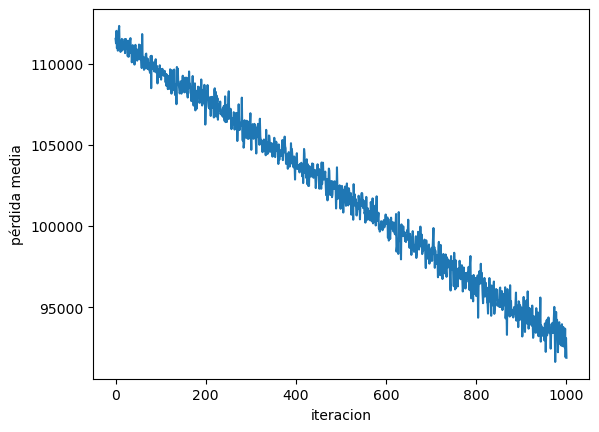

In [25]:
import matplotlib.pyplot as plt
plt.plot(range(Iteration+1),perdida)
plt.xlabel("iteracion")
plt.ylabel("pérdida media")
plt.show()

In [ ]:
!pip install tqdm

In [ ]:
print(inner_loop)

50


In [26]:
print(image_syn_train)

tensor([[ 1.3844, -0.7908,  0.2638,  ..., -0.8099,  0.5453,  0.1349],
        [ 1.1817, -0.9725, -0.7473,  ...,  0.7826, -0.9204, -0.9795],
        [ 2.1735,  0.7451,  1.0009,  ..., -0.7461, -0.2051, -0.2961],
        ...,
        [ 0.5990, -0.2597,  0.7415,  ..., -0.5089, -0.3006,  0.1411],
        [-0.9876,  1.8570, -0.3894,  ..., -0.1392, -0.7651, -1.0010],
        [ 0.5430, -0.3549,  0.8774,  ..., -0.0813, -0.2474, -1.1371]],
       device='cuda:0')


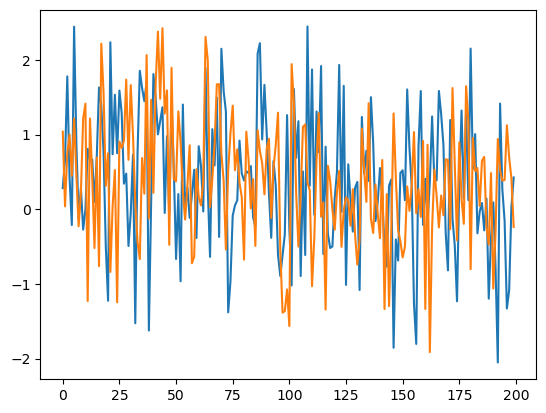

In [9]:
import torch
import matplotlib.pyplot as plt
img=torch.load("resultados/Sat Sep 23 09:41:36 2023/imgs")
plt.plot(range(200),img[0].cpu().detach().numpy())
plt.plot(range(200),img[1].cpu().detach().numpy())

In [10]:
etq=torch.load("resultados/Sat Sep 23 09:41:36 2023/etiquetas")
print(etq)

tensor([15, 15, 15, 15, 15, 15, 15, 15, 15, 15], device='cuda:0')


In [27]:
accs = []
net_eval=Baseline(channel,num_classes).to(device)
image_syn_eval, label_syn_eval = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach()) # evitar cualquier modificación inconsciente
for it_eval in range(num_eval):
    # Trains a model in syntethic data, epoch_eval_train = 1000
    _, acc_train, acc_test = epoch(net_eval, image_syn_eval, label_syn_eval, testloader, lr_net, batch_train, device, epoch_eval_train)
    accs.append(acc_test)


Evaluate: epoch = 0100, train loss = 1.272360, train acc = 0.8875, test acc = 0.0395
Evaluate: epoch = 0100, train loss = 0.551109, train acc = 1.0000, test acc = 0.0298
Evaluate: epoch = 0100, train loss = 0.298413, train acc = 1.0000, test acc = 0.0459
Evaluate: epoch = 0100, train loss = 0.194394, train acc = 1.0000, test acc = 0.0468
Evaluate: epoch = 0100, train loss = 0.141345, train acc = 1.0000, test acc = 0.0468
Evaluate: epoch = 0100, train loss = 0.109977, train acc = 1.0000, test acc = 0.0473
Evaluate: epoch = 0100, train loss = 0.089553, train acc = 1.0000, test acc = 0.0468
Evaluate: epoch = 0100, train loss = 0.075272, train acc = 1.0000, test acc = 0.0468
Evaluate: epoch = 0100, train loss = 0.064784, train acc = 1.0000, test acc = 0.0468
Evaluate: epoch = 0100, train loss = 0.056778, train acc = 1.0000, test acc = 0.0449
Evaluate: epoch = 0100, train loss = 0.050481, train acc = 1.0000, test acc = 0.0449
Evaluate: epoch = 0100, train loss = 0.045393, train acc = 1.0000

In [30]:
print(image_syn_train.shape)
print(images_all.shape)

torch.Size([160, 200])
torch.Size([8199, 200])


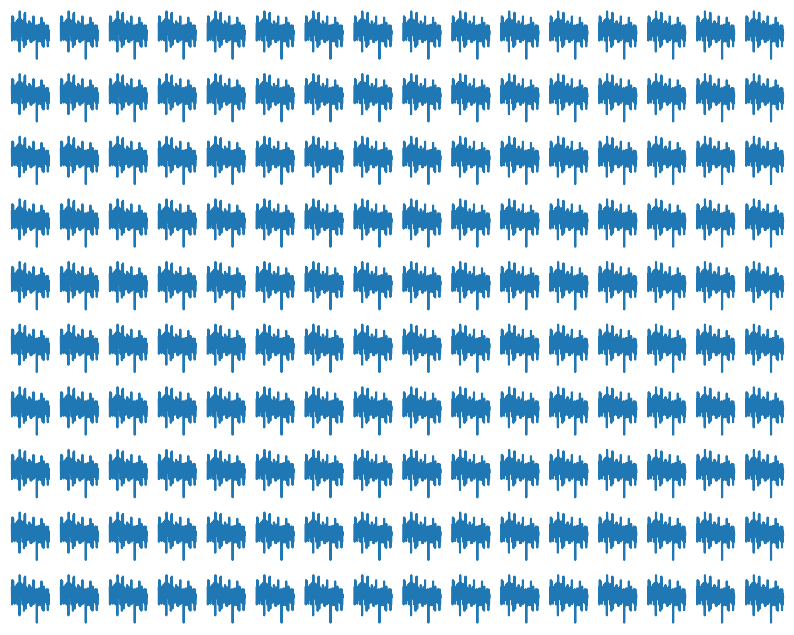

In [28]:
def print_syn_img():
    fig, axes = plt.subplots(ipc,num_classes, figsize=(10, 8))

    images_print, labels_print = copy.deepcopy(image_syn.detach()).cpu().detach().numpy(), copy.deepcopy(label_syn.detach()).cpu().detach().numpy()
    if ipc==1:
        for i in range(num_classes):
            #axes[i].imshow(np.squeeze(images_print[i],axis=0))
            axes[i].plot(np.squeeze(images_print[i],axis=0))
            axes[i].axis('off')

    else:
        k=0
        for i in range(num_classes):
            for j in range(ipc):
                if len(images_all[0].shape)==1:
                    axes[j,i].plot(range(len(images_print[j])),images_print[k])
                    axes[j,i].axis('off')
                else:
                    axes[i,j].imshow(np.squeeze(images_print[k],axis=0))
                    k+=1
                    axes[i,j].axis('off')
print_syn_img()